<a href="https://colab.research.google.com/github/RuHae/TGM_Project/blob/main/Code/C_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TODO**


* plot_reconstructed allows classes
* remove hardcoded dimensions
* refine architecture e.g. use RELU, more layer



In [1]:
! pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 7.0 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=95340c20194844c9c56dd485f0a3362e904bcba2f9d31953a5006c8721818a19
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
!nvcc --version
!pip install torch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |██████████████████████████▌     | 834.1 MB 1.2 MB/s eta 0:02:20tcmalloc: large alloc 1147494400 bytes == 0x38f08000 @  0x7fcf00dab615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 1007.8 MB 1.3 MB/s eta 0:00:01tcmalloc: large alloc 1259798528 bytes == 0xb9684000 @  0x7fcf00dab615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x511e2c 0x549576 0x593f

In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import medmnist
from medmnist import INFO, Evaluator
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.utils.data as data
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"


In [ ]:
torch.version.cuda

'11.3'

In [3]:
# sources: https://www.tensorflow.org/tutorials/generative/cvae
# https://github.com/unnir/cVAE/blob/master/cvae.py
class Encoder(nn.Module):
    def __init__(self, feature_size, latent_dims, mode, channels, class_size):
        super(Encoder, self).__init__()
        self.channels = channels
        self.class_size = class_size
        self.feature_size = feature_size
        self.latent_dims = latent_dims
        self.mode = mode
        # 28*28*3
        #self.fc1  = nn.Linear(self.feature_size+self.class_size, 512)
        self.fc1  = nn.Linear((12*6*6)+class_size, 128) # hard coded size after convolutions
        self.fc2  = nn.Linear(256, 128)
        self.fc21 = nn.Linear(128, self.latent_dims)
        self.fc22 = nn.Linear(128, self.latent_dims)
        self.conv1 = nn.Conv2d(self.channels, 6, 3, stride=2)
        self.conv2 = nn.Conv2d(6, 12, 3, stride=2)   
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(12)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

       # self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.to("cuda:0")#.cuda() # hack to get sampling on the GPU
        #self.N.scale = self.N.scale.to("cuda:0")#.cuda()
        #self.kl = 0

    # this is for the beta vae
    def sampling_beta(self, x):
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        # to keep the latent in the region of N(0,1)
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        # self.kl = ((sigma**2 + mu**2)/2 - torch.log(sigma) - 1/2).sum()
        self.kl = 0.5 * torch.sum(torch.exp(sigma) + mu**2 - 1 - sigma)
        return z

    def forward(self, x, c):
        nsamples = 100
        x = self.relu((self.conv1(x)))
        x = self.relu((self.conv2(x)))
        inputs = torch.cat([x.view(-1, x.shape[1]*x.shape[2]*x.shape[3]), c], 1) # (bs, feature_size+class_size)
        h1 = self.relu(self.fc1(inputs))
        #h2 = self.relu(self.fc2(h1))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

class Decoder(nn.Module):
    def __init__(self, feature_size, latent_dims, mode, channels, class_size):
        super(Decoder, self).__init__()
        self.channels = channels
        self.class_size = class_size
        self.feature_size = feature_size
        self.latent_dims = latent_dims
        #self.fc3 = nn.Linear(self.latent_dims + self.class_size, 256)
        self.fc3 = nn.Linear(self.latent_dims + self.class_size, 432)
        #self.fc4 = nn.Linear(256, 432) # for generating convolutional image
        #self.fc4 = nn.Linear(256, 256) # for generating convolutional image
        self.conv1 = nn.ConvTranspose2d(12,6,3, stride=2)
        self.conv2 = nn.ConvTranspose2d(6,3,3, stride=2, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(3,self.channels,1, stride=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.bn2 = nn.BatchNorm2d(3)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, c):
        inputs = torch.cat([z, c], 1) # (bs, latent_size+class_size)
        h3 = self.relu(self.fc3(inputs))
        #h4 = self.relu(self.fc4(h3))
        h4 = h3.reshape(-1, 12, 6, 6) 
        h5 = self.relu(self.conv1(h4))
        h6 = self.relu(self.conv2(h5))
        #h7 = self.sigmoid(self.conv3(h6))
        h7 = self.sigmoid(self.conv3(h6))
        return h7.reshape((-1, self.channels, 28, 28))


class VariationalAutoencoder(nn.Module):
    def __init__(self, feature_size, latent_dims, mode, channels, class_size):
        super(VariationalAutoencoder, self).__init__()
        self.channels = channels
        self.feature_size = feature_size
        self.class_size = class_size
        self.mode = mode
        self.encoder = Encoder(self.feature_size, latent_dims, self.mode, self.channels, self.class_size)
        self.decoder = Decoder(self.feature_size, latent_dims, self.mode, self.channels, self.class_size)
    
    def forward(self, x, c):
        mu, logvar = self.encoder.forward(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decoder.forward(z, c), mu, logvar

    def one_hot(self,labels, class_size):
      targets = torch.zeros(labels.size(0), class_size)
      for i, label in enumerate(labels):
        targets[i, label] = 1
      return targets.to(device)

    def reparameterize(self, mu, logvar):
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      return mu + eps*std
  
    # Reconstruction + KL divergence losses summed over all elements and batch
    def loss_function(self, recon_x, x, mu, logvar):
      BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
      # see Appendix B from VAE paper:
      # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
      # https://arxiv.org/abs/1312.6114
      # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      return BCE + KLD, BCE, KLD
    
    def train(self, data, epochs=5, lr=0.001, device="cpu", fast=False):
        # only for fast training
        opt = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            i = 0
            train_loss = 0
            for x, y in tqdm(data):
                if fast and i > nsamples:
                    break
                i= i + 1
                # print(x.shape)
                x = x.to(device) # GPU
                y = self.one_hot(y, self.class_size)
                # for sample in x:
                x_hat, mu, logvar = self.forward(x, y)
                opt.zero_grad()
                loss, bce, kld = self.loss_function(x_hat, x, mu, logvar)
                loss.backward()
                train_loss += loss.detach().cpu().numpy()
                opt.step()
                
                #loss = diff + self.encoder.kl             
                # loss = self.encoder.kl                              
                # loss = bce + 10 * self.encoder.kl + diff                        
                #loss.backward()
                #opt.step()
            print("Iteration:", epoch, "Loss:", loss.item(), "KLD:", kld.item(), "BCE:", bce.item())

In [4]:
#data_flag = 'pathmnist'
#data_flag = 'bloodmnist'
data_flag = 'organamnist'
# data_flag = 'breastmnist'
#data_flag = 'octmnist'
# data_flag = 'chestmnist'
# data_flag = 'tissuemnist'
download = True

# hyper params
batch_size = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/38247903 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz


In [5]:
latent_dims = 64
channels = 1
img_heigt = 28
img_width = 28
lr = 0.01
epochs = 10
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu' # if no access to GPU 
vae = VariationalAutoencoder(28*28*channels, latent_dims, mode="conditional", channels=channels, class_size=n_classes).to(device)

vae.train(train_loader, lr=lr, epochs=epochs, device=device)

100%|██████████| 541/541 [00:12<00:00, 42.16it/s]


Iteration: 0 Loss: 10604.9736328125 KLD: 139.61260986328125 BCE: 10465.361328125


100%|██████████| 541/541 [00:11<00:00, 46.33it/s]


Iteration: 1 Loss: 10447.2880859375 KLD: 184.3435821533203 BCE: 10262.9443359375


100%|██████████| 541/541 [00:17<00:00, 31.04it/s]


Iteration: 2 Loss: 9645.3984375 KLD: 218.9850311279297 BCE: 9426.4130859375


100%|██████████| 541/541 [00:11<00:00, 46.06it/s]


Iteration: 3 Loss: 9602.6904296875 KLD: 226.4593048095703 BCE: 9376.2314453125


100%|██████████| 541/541 [00:11<00:00, 46.26it/s]


Iteration: 4 Loss: 9098.77734375 KLD: 205.37753295898438 BCE: 8893.3994140625


100%|██████████| 541/541 [00:12<00:00, 42.32it/s]


Iteration: 5 Loss: 10090.060546875 KLD: 234.88955688476562 BCE: 9855.1708984375


100%|██████████| 541/541 [00:11<00:00, 45.83it/s]


Iteration: 6 Loss: 8998.17578125 KLD: 239.80892944335938 BCE: 8758.3671875


100%|██████████| 541/541 [00:11<00:00, 45.88it/s]


Iteration: 7 Loss: 10009.677734375 KLD: 211.9632568359375 BCE: 9797.71484375


100%|██████████| 541/541 [00:11<00:00, 46.21it/s]


Iteration: 8 Loss: 9436.359375 KLD: 218.94456481933594 BCE: 9217.4150390625


100%|██████████| 541/541 [00:12<00:00, 43.77it/s]

Iteration: 9 Loss: 10014.9931640625 KLD: 193.6864013671875 BCE: 9821.306640625


In [6]:
vae.train(train_loader, lr=lr, epochs=epochs, device=device)

100%|██████████| 541/541 [00:11<00:00, 47.91it/s]


Iteration: 0 Loss: 10098.3447265625 KLD: 218.40036010742188 BCE: 9879.9443359375


100%|██████████| 541/541 [00:11<00:00, 47.66it/s]


Iteration: 1 Loss: 9820.0234375 KLD: 216.57693481445312 BCE: 9603.4462890625


100%|██████████| 541/541 [00:11<00:00, 47.38it/s]


Iteration: 2 Loss: 9687.9482421875 KLD: 221.62689208984375 BCE: 9466.3212890625


100%|██████████| 541/541 [00:11<00:00, 47.87it/s]


Iteration: 3 Loss: 9683.046875 KLD: 247.69515991210938 BCE: 9435.3515625


100%|██████████| 541/541 [00:11<00:00, 47.41it/s]


Iteration: 4 Loss: 9292.953125 KLD: 230.34912109375 BCE: 9062.6044921875


100%|██████████| 541/541 [00:11<00:00, 47.83it/s]


Iteration: 5 Loss: 9753.9111328125 KLD: 252.89706420898438 BCE: 9501.013671875


100%|██████████| 541/541 [00:11<00:00, 47.46it/s]


Iteration: 6 Loss: 10199.205078125 KLD: 201.56228637695312 BCE: 9997.642578125


100%|██████████| 541/541 [00:11<00:00, 47.55it/s]


Iteration: 7 Loss: 8619.03515625 KLD: 264.7295227050781 BCE: 8354.3056640625


100%|██████████| 541/541 [00:11<00:00, 47.37it/s]


Iteration: 8 Loss: 10094.8095703125 KLD: 217.39541625976562 BCE: 9877.4140625


100%|██████████| 541/541 [00:11<00:00, 47.48it/s]

Iteration: 9 Loss: 9650.5087890625 KLD: 215.5552215576172 BCE: 9434.953125


In [8]:
vae.train(train_loader, lr=lr, epochs=epochs, device=device)

100%|██████████| 541/541 [00:11<00:00, 47.44it/s]


Iteration: 0 Loss: 9342.5712890625 KLD: 246.65155029296875 BCE: 9095.919921875


100%|██████████| 541/541 [00:11<00:00, 47.56it/s]


Iteration: 1 Loss: 8747.3310546875 KLD: 253.6173858642578 BCE: 8493.7138671875


100%|██████████| 541/541 [00:11<00:00, 47.79it/s]


Iteration: 2 Loss: 10085.2734375 KLD: 197.4281768798828 BCE: 9887.845703125


100%|██████████| 541/541 [00:11<00:00, 47.47it/s]


Iteration: 3 Loss: 9247.4365234375 KLD: 255.39901733398438 BCE: 8992.037109375


100%|██████████| 541/541 [00:11<00:00, 47.43it/s]


Iteration: 4 Loss: 9517.5693359375 KLD: 256.8388671875 BCE: 9260.73046875


100%|██████████| 541/541 [00:11<00:00, 47.61it/s]


Iteration: 5 Loss: 9577.484375 KLD: 240.3390655517578 BCE: 9337.1455078125


100%|██████████| 541/541 [00:11<00:00, 47.84it/s]


Iteration: 6 Loss: 9669.1259765625 KLD: 223.69143676757812 BCE: 9445.4345703125


100%|██████████| 541/541 [00:11<00:00, 47.47it/s]


Iteration: 7 Loss: 8925.1162109375 KLD: 275.43756103515625 BCE: 8649.6787109375


100%|██████████| 541/541 [00:11<00:00, 48.01it/s]


Iteration: 8 Loss: 9792.328125 KLD: 248.92529296875 BCE: 9543.40234375


100%|██████████| 541/541 [00:11<00:00, 47.58it/s]

Iteration: 9 Loss: 9530.494140625 KLD: 248.13882446289062 BCE: 9282.35546875


In [9]:
vae.train(train_loader, lr=lr, epochs=epochs, device=device)

100%|██████████| 541/541 [00:11<00:00, 47.54it/s]


Iteration: 0 Loss: 10326.470703125 KLD: 194.48606872558594 BCE: 10131.984375


100%|██████████| 541/541 [00:11<00:00, 47.46it/s]


Iteration: 1 Loss: 9706.4248046875 KLD: 225.34939575195312 BCE: 9481.0751953125


100%|██████████| 541/541 [00:11<00:00, 47.53it/s]


Iteration: 2 Loss: 9657.0517578125 KLD: 245.87808227539062 BCE: 9411.173828125


100%|██████████| 541/541 [00:11<00:00, 47.11it/s]


Iteration: 3 Loss: 9872.171875 KLD: 235.073974609375 BCE: 9637.09765625


100%|██████████| 541/541 [00:11<00:00, 47.17it/s]


Iteration: 4 Loss: 9577.3984375 KLD: 209.5631561279297 BCE: 9367.8349609375


100%|██████████| 541/541 [00:11<00:00, 47.17it/s]


Iteration: 5 Loss: 9856.138671875 KLD: 232.236572265625 BCE: 9623.90234375


100%|██████████| 541/541 [00:11<00:00, 46.83it/s]


Iteration: 6 Loss: 9261.9423828125 KLD: 227.1422119140625 BCE: 9034.7998046875


100%|██████████| 541/541 [00:11<00:00, 47.08it/s]


Iteration: 7 Loss: 9514.0673828125 KLD: 230.04367065429688 BCE: 9284.0234375


100%|██████████| 541/541 [00:11<00:00, 47.27it/s]


Iteration: 8 Loss: 9908.11328125 KLD: 220.94451904296875 BCE: 9687.1689453125


100%|██████████| 541/541 [00:11<00:00, 46.68it/s]

Iteration: 9 Loss: 8737.1904296875 KLD: 247.0515594482422 BCE: 8490.138671875


In [10]:
vae.train(train_loader, lr=lr, epochs=epochs, device=device)

100%|██████████| 541/541 [00:11<00:00, 46.52it/s]


Iteration: 0 Loss: 9380.9140625 KLD: 217.26370239257812 BCE: 9163.650390625


100%|██████████| 541/541 [00:11<00:00, 46.19it/s]


Iteration: 1 Loss: 8802.94140625 KLD: 259.828125 BCE: 8543.11328125


100%|██████████| 541/541 [00:11<00:00, 46.73it/s]


Iteration: 2 Loss: 10014.5419921875 KLD: 223.08172607421875 BCE: 9791.4599609375


100%|██████████| 541/541 [00:11<00:00, 47.37it/s]


Iteration: 3 Loss: 9176.1982421875 KLD: 216.435302734375 BCE: 8959.7626953125


100%|██████████| 541/541 [00:11<00:00, 47.61it/s]


Iteration: 4 Loss: 10040.6171875 KLD: 252.6500244140625 BCE: 9787.966796875


100%|██████████| 541/541 [00:11<00:00, 47.11it/s]


Iteration: 5 Loss: 9363.4189453125 KLD: 271.07122802734375 BCE: 9092.34765625


100%|██████████| 541/541 [00:11<00:00, 46.84it/s]


Iteration: 6 Loss: 9822.6103515625 KLD: 239.51853942871094 BCE: 9583.091796875


100%|██████████| 541/541 [00:11<00:00, 46.79it/s]


Iteration: 7 Loss: 8975.33984375 KLD: 270.4532470703125 BCE: 8704.88671875


100%|██████████| 541/541 [00:11<00:00, 47.23it/s]


Iteration: 8 Loss: 9081.1640625 KLD: 240.80429077148438 BCE: 8840.359375


100%|██████████| 541/541 [00:11<00:00, 47.06it/s]

Iteration: 9 Loss: 9205.7392578125 KLD: 251.73330688476562 BCE: 8954.005859375


In [11]:
vae.train(train_loader, lr=lr, epochs=epochs, device=device)

100%|██████████| 541/541 [00:11<00:00, 47.37it/s]


Iteration: 0 Loss: 9983.38671875 KLD: 240.73794555664062 BCE: 9742.6484375


100%|██████████| 541/541 [00:11<00:00, 47.34it/s]


Iteration: 1 Loss: 10114.275390625 KLD: 235.88121032714844 BCE: 9878.39453125


100%|██████████| 541/541 [00:11<00:00, 47.12it/s]


Iteration: 2 Loss: 9008.7490234375 KLD: 269.15753173828125 BCE: 8739.591796875


100%|██████████| 541/541 [00:11<00:00, 47.12it/s]


Iteration: 3 Loss: 10667.3203125 KLD: 197.73728942871094 BCE: 10469.5830078125


100%|██████████| 541/541 [00:11<00:00, 47.50it/s]


Iteration: 4 Loss: 9897.16796875 KLD: 205.9034881591797 BCE: 9691.2646484375


100%|██████████| 541/541 [00:11<00:00, 47.55it/s]


Iteration: 5 Loss: 9268.1083984375 KLD: 272.6486511230469 BCE: 8995.4599609375


100%|██████████| 541/541 [00:11<00:00, 47.37it/s]


Iteration: 6 Loss: 9445.0078125 KLD: 255.85121154785156 BCE: 9189.15625


100%|██████████| 541/541 [00:11<00:00, 47.14it/s]


Iteration: 7 Loss: 10112.6533203125 KLD: 248.91070556640625 BCE: 9863.7421875


100%|██████████| 541/541 [00:11<00:00, 46.65it/s]


Iteration: 8 Loss: 9777.4599609375 KLD: 278.9043884277344 BCE: 9498.5556640625


100%|██████████| 541/541 [00:11<00:00, 47.05it/s]

Iteration: 9 Loss: 9986.2197265625 KLD: 246.14964294433594 BCE: 9740.0703125


In [12]:
vae.train(train_loader, lr=lr, epochs=epochs, device=device)

100%|██████████| 541/541 [00:11<00:00, 47.05it/s]


Iteration: 0 Loss: 9812.490234375 KLD: 251.5319061279297 BCE: 9560.9580078125


100%|██████████| 541/541 [00:11<00:00, 46.82it/s]


Iteration: 1 Loss: 9348.5458984375 KLD: 272.471923828125 BCE: 9076.07421875


100%|██████████| 541/541 [00:11<00:00, 47.10it/s]


Iteration: 2 Loss: 9041.669921875 KLD: 255.66397094726562 BCE: 8786.005859375


100%|██████████| 541/541 [00:11<00:00, 47.18it/s]


Iteration: 3 Loss: 8755.2861328125 KLD: 324.3740539550781 BCE: 8430.912109375


100%|██████████| 541/541 [00:11<00:00, 47.37it/s]


Iteration: 4 Loss: 9483.3896484375 KLD: 245.62542724609375 BCE: 9237.7646484375


100%|██████████| 541/541 [00:11<00:00, 47.13it/s]


Iteration: 5 Loss: 9611.818359375 KLD: 236.80291748046875 BCE: 9375.015625


100%|██████████| 541/541 [00:11<00:00, 47.25it/s]


Iteration: 6 Loss: 9961.8134765625 KLD: 192.9400634765625 BCE: 9768.873046875


100%|██████████| 541/541 [00:11<00:00, 47.07it/s]


Iteration: 7 Loss: 9296.3369140625 KLD: 283.59173583984375 BCE: 9012.7451171875


100%|██████████| 541/541 [00:11<00:00, 46.92it/s]


Iteration: 8 Loss: 9784.5205078125 KLD: 246.82943725585938 BCE: 9537.69140625


100%|██████████| 541/541 [00:11<00:00, 46.96it/s]

Iteration: 9 Loss: 9391.126953125 KLD: 257.1777648925781 BCE: 9133.94921875


In [13]:
vae.train(train_loader, lr=lr, epochs=epochs, device=device)

100%|██████████| 541/541 [00:11<00:00, 46.94it/s]


Iteration: 0 Loss: 8880.8212890625 KLD: 274.5549621582031 BCE: 8606.2666015625


100%|██████████| 541/541 [00:11<00:00, 47.24it/s]


Iteration: 1 Loss: 9181.7119140625 KLD: 302.05682373046875 BCE: 8879.6552734375


100%|██████████| 541/541 [00:11<00:00, 47.43it/s]


Iteration: 2 Loss: 9137.5234375 KLD: 277.0059814453125 BCE: 8860.517578125


100%|██████████| 541/541 [00:11<00:00, 47.45it/s]


Iteration: 3 Loss: 9424.435546875 KLD: 226.15231323242188 BCE: 9198.283203125


100%|██████████| 541/541 [00:11<00:00, 47.23it/s]


Iteration: 4 Loss: 10180.8017578125 KLD: 219.3225555419922 BCE: 9961.4794921875


100%|██████████| 541/541 [00:11<00:00, 47.68it/s]


Iteration: 5 Loss: 9570.693359375 KLD: 241.86936950683594 BCE: 9328.82421875


100%|██████████| 541/541 [00:11<00:00, 47.51it/s]


Iteration: 6 Loss: 10433.720703125 KLD: 211.40023803710938 BCE: 10222.3203125


100%|██████████| 541/541 [00:11<00:00, 47.75it/s]


Iteration: 7 Loss: 8801.3828125 KLD: 250.1842498779297 BCE: 8551.1982421875


100%|██████████| 541/541 [00:11<00:00, 47.29it/s]


Iteration: 8 Loss: 9881.767578125 KLD: 220.66363525390625 BCE: 9661.103515625


100%|██████████| 541/541 [00:11<00:00, 46.32it/s]

Iteration: 9 Loss: 9744.794921875 KLD: 224.21011352539062 BCE: 9520.5849609375


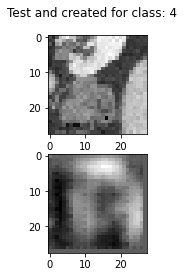

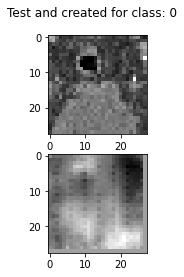

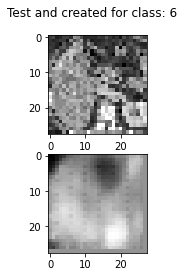

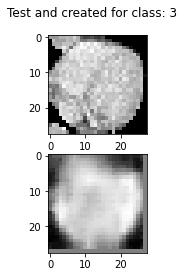

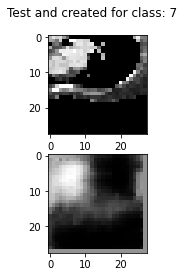

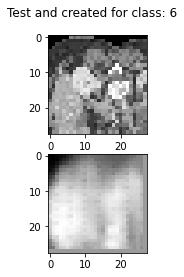

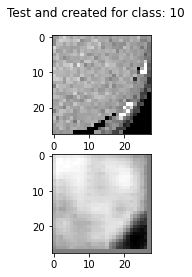

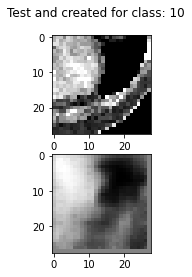

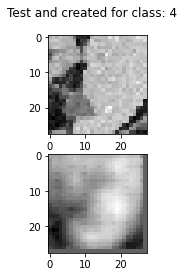

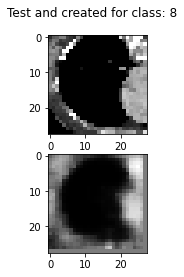

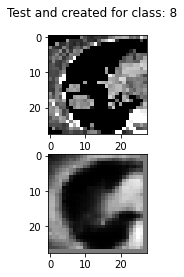

In [14]:
max_index = 17778 #blood=3421, , path=7180, organAMNIST=17778
c_size = n_classes
for r in range(0,c_size):
  index = random.randint(0, max_index)
  test_img = test_dataset[index][0][None,:,:,:].to(device)
  test_c = test_dataset[index][1][None,:]
  c = torch.LongTensor(test_c).to(device)
  c = vae.one_hot(c,c_size)
  #print(c)
  img, mu, log = vae.forward(test_img,c)
  fig, axs = plt.subplots(2)
  fig.suptitle('Test and created for class: ' + str(test_dataset[index][1][0]))
  if channels < 3:
   axs[0].imshow(test_img[0,0,:,:].moveaxis(0, 1).cpu().detach().numpy(), cmap="gray")
   axs[1].imshow(img[0,0,:,:].moveaxis(0, 1).cpu().detach().numpy(), cmap="gray")
  else:
    axs[0].imshow(test_img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
    axs[1].imshow(img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
  plt.plot()

In [ ]:
# maybe CVAE is not able to generate better results: https://openaccess.thecvf.com/content_ICCV_2017/papers/Bao_CVAE-GAN_Fine-Grained_Image_ICCV_2017_paper.pdf

In [ ]:
def plot_latent(autoencoder, data, num_batches=64, class_size=1):
    for i, (x, y) in enumerate(data):
        labels = vae.one_hot(y,class_size)
        z_mu, z_var = autoencoder.encoder.forward(x.to(device), labels.to(device))
        z_mu = z_mu.to('cpu').detach().numpy()
        z_var = z_var.to('cpu').detach().numpy()
        N= torch.distributions.Normal(0, 1)
        z = z_mu + z_var* N.sample(z_mu.shape).detach().numpy()
        colors = y.to('cpu').detach().numpy()
        plt.scatter(z[:,0], z[:,1], c=colors[:,0], cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

In [ ]:
plot_latent(vae, train_loader, class_size=8)

In [ ]:
c_size = 8
c_idx = 0
for c_size in range (0,c_size):
  #index = random.randint(0, 100)
  print(len(test_dataset.labels))
  for idx in range(0,len(test_dataset.labels)):
    #print(test_dataset.labels[idx][0][0])
    print(test_dataset.labels.index(c))
    if test_dataset.labels[idx][0] == c:
      print(test_dataset.labels[idx])
      c_idx = idx
      print(c_idx)
    test_img = test_dataset[c_idx][0][None,:,:,:].to(device)
    test_c = test_dataset.labels[c_idx][0]
    print(test_c)
    c = torch.LongTensor(test_c).to(device)
    c = vae.one_hot(c,c_size)
    img, mu, log = vae.forward(test_img,c)
    fig, axs = plt.subplots(2)
    fig.suptitle('Test and created')
    axs[0].imshow(test_img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
    axs[1].imshow(img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
  plt.plot()

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12, latent_dim=2):
    w = 28
    c_size = 8
    img = np.zeros((n*w, n*w,3))
    c = [(random.randint(0, c_size))]
    c = torch.LongTensor(c)[None,:]
    c = autoencoder.one_hot(c,c_size)
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.randint(-1,1, (1,latent_dims), dtype=torch.float, device=device)
            # z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z,c)
            # print(z)
            x_hat = x_hat.reshape(3, 28, 28).moveaxis(0,2).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w,:] = x_hat
    plt.figure(figsize=(10,10))
    plt.imshow(img, extent=[*r0, *r1])
    plt.show()

In [ ]:
#plot_reconstructed(vae, r0=(-1, 1), r1=(-1, 1), latent_dim=latent_dims)

In [ ]:
i = torch.randn((3, 28, 28))
conv1 = nn.Conv2d(3, 6, 3, stride=2)
conv2 = nn.Conv2d(6, 12, 3, stride=2)   
bn1 = nn.BatchNorm2d(6)
bn2 = nn.BatchNorm2d(12)
relu = nn.ReLU()
x =relu(bn1(conv1(i)[None, :]))
#print(x.shape)
x = relu(bn2(conv2(x)))
#print(x.shape)
#print(x.shape[1])

i = torch.randn((12, 3, 3))
conv1 = nn.ConvTranspose2d(12,6,3, stride=2)
conv2 = nn.ConvTranspose2d(6,3,3, stride=2, output_padding=1)
conv3 = nn.ConvTranspose2d(3,3,1, stride=1)

x = conv1(i)
x = conv2(x)
print(x.shape)
x = conv3(x)
print(x.shape)